# Modelo

Este modelo consiste em otimizar o valor de custo de uma solução sujeito a Capacidade Residual. 
Aqui o valor de custo consiste no somatório do custo de todas as árvores.

O modelo matemático é definido como:

$$ Minimizar \sum_{ (i,j) \in E}^{k} y_{ij}^{k}* custo_{ij} \quad \forall k \in K$$

$$\mbox{Subject to:}$$

$$\sum_{i \in V}{x_{ir_k}^{kd}} - \sum_{i \in V}{x_{r_{k}i}^{kd}} = -1\quad {\forall k \in K \atop \forall d \in D^k}$$

$$\sum_{(i,d) \in E}{x_{id}^{kd}} - \sum_{(d,i) \in E}{x_{di}^{kd}} = 1 \quad {\forall k \in K \atop \forall d \in D^k}$$

$$\sum_{(i,j) \in E \atop j \neq r_k,d}{x_{ij}^{kd}} - \sum_{(i,j) \in E \atop j \neq r_k,d}{x_{ji}^{kd}} = 0 \quad {\forall k \in K \atop \forall d \in D^k}$$

$$x_{ij}^{kd} \leq y_{ij}^{k} \quad \forall k \in K, d \in D^k  \text{ e }  \forall (i,j) \in E$$

$$\sum_{d \in D^k}{x_{ij}^{kd}} - y_{ij}^{k} \geq 0 \quad \forall k \in K$$

$$b_{ij}  \geq \sum_{k \in K} y_{ij}^{k} t^k \quad \forall (i,j) \in E$$

$$b_{ij}  - \sum_{k \in K} y_{ij}^{k} t^k >= Z \quad \forall (i,j) \in E$$

$$x_{ij}^{kd} \in \lbrace 0, 1 \rbrace , y_{ij}^{k} \in \lbrace 0, 1 \rbrace  {{\forall k \in K,  \forall d \in D^k} \atop \forall (i,j) \in E}$$


Observe-se que a restrição $b_{ij}  - \sum_{k \in K} y_{ij}^{k} t^k >= Z \quad \forall (i,j) \in E$ garante que a solução terá uma reserva de banda pelo menos igual a Z. Este fator é importante para otimização, pois sua variação pode levar mudanças no custo.


In [60]:
from classes import Network, MulticastGroup
from multicastpacking import MulticastPacking, solver
import reader

#instancen of the problem
file = "../../../MPP_instances/n30/b30_1.brite"

In [61]:
links = reader.get_network (file)
net = Network (links, nodes = 30)


mgroups = [MulticastGroup (g) for g in reader.get_groups (file) ]

problem = MulticastPacking (net, mgroups)

In [62]:
KSIZE = len(problem.groups)+1
NODES = net.nodes+1

## Criando a variável:  
$$x_{ij}^{kd}$$

In [63]:
from gurobipy import *

m = Model ("MPP by Cost")

var_x = {}
var_y = {}

for link in net.links:
    for k in xrange (1, KSIZE):
        for d in problem.groups[k-1].members:
            x=link[0],link[1],k,d,
            y=link[1],link[0],k,d,
            var_x[x] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(x))
            var_x[y] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
            
m.update ()



## Criando variável 
$$y_{ij}^{k}$$

In [64]:
for k in xrange (1, KSIZE):
    for link in net.links:
        x=link[0],link[1],k
        y=link[1],link[0],k
        var_y[x] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(x))
        var_y[y] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))

m.update ()

## Fluxo 1:  

$$\sum_{i \in V} x_{ij}^{kd} - \sum_{i \in V} x_{ji}^{kd} = -1 \quad \forall k \in K,\forall d \in D^k$$

In [65]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        sk = problem.groups[k-1].source
        _name='flow1',k,d
        m.addConstr (
            quicksum ( var_x[x] for x in tuplelist (var_x).select ('*',sk,k,d) )
            -
            quicksum ( var_x[x] for x in tuplelist (var_x).select (sk,'*',k,d) )
            == -1,
            name=str(_name)
        )

m.update ()

## Fluxo 2:  

$$\sum_{(i,j) \in E,  j \notin [r_k, d]} x_{ji}^{kd} - \sum_{(i,j) \in E, j \notin [r_k, d]} x_{ji}^{kd} = 0 \quad \forall k \in K,\forall d \in D^k$$

In [66]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        for j in xrange(1,NODES):
            sk = problem.groups[k-1].source
            _name='flow2',k,d,j,       
            m.addConstr (
                quicksum(
                   var_x[x] for x in tuplelist (var_x).select ('*',j,k,d) 
                    if x[1] not in [sk, d]
                )
                -
                quicksum(
                    var_x[x] for x in tuplelist (var_x).select (j,'*',k,d) 
                    if x[0] not in [sk, d]
                )
                == 0,
                name=str(_name)
            )            

m.update ()

## Fluxo 3: 

$$\sum_{(d,i) \in E} x_{di}^{kd} - \sum_{(i,d) \in E} x_{id}^{kd} = 1 \quad \forall k \in K,\forall d \in D^k$$

In [67]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        sk = problem.groups[k-1].source
        _name='flow3',k,d
        m.addConstr (
            quicksum (
                var_x[x] for x in tuplelist (var_x).select ('*',d,k,d)
            )
            -
            quicksum (
                var_x[x] for x in tuplelist (var_x).select (d,'*',k,d)
            )
            == 1,
            name=str(_name)
        )
        
m.update ()

## Restrição que Força $y_{ij}^{k}$ ser igual 1 se a aresta $(i,j)$ é usada por alguma árvore:

$$x_{ij}^{kd} \leq y_{ij}^{k} \quad \forall k \in K, d \in D^k  \text{ e }  \forall (i,j) \in E$$

In [68]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        for link in net.links:
            x=link[0],link[1],k,d,
            y=link[0],link[1],k
            _name='mark',link[0],link[1],k,d
            m.addConstr ( var_x[x] <= var_y[y], 
                name=str(_name)
            )            
            x=link[1],link[0],k,d,
            y=link[1],link[0],k
            _name='mark',link[1],link[0],k,d
            m.addConstr ( var_x[x] <= var_y[y], 
                name=str(_name)
            )
m.update ()

## Restrição que evita nós folhas não terminais:
$$\sum_{d \in D^k}{x_{ij}^{kd}} - y_{ij}^{k} \geq 0 \quad \forall k \in K$$

In [69]:
for k in xrange(1,KSIZE):
    for link in net.links:
        _name='out',link[0],link[1],k
        m.addConstr(
            quicksum(
                  var_x[x] for x in tuplelist (var_x).select (link[0],link[1],k,'*')              
            )
            -
            var_y[link[0],link[1],k]
            >=
            0,
            name=str(_name)
        )
        _name='out',link[1],link[0],k,
        
        m.addConstr(
            quicksum(
                  var_x[x] for x in tuplelist (var_x).select (link[1],link[0],k,'*')              
            )
            -
            var_y[link[1],link[0],k]
            >=
            0,
            name=str(_name)
        )
m.update()

## Conjunto de Restrições que foça uma capacidade residual mínima:

$$b_{ij}  - \sum_{k \in K} y_{ij}^{k} t^k >= Z \quad \forall (i,j) \in E$$

In [70]:
Z = 32

constr = []

for link in net.links:    
    _name='capacity',link
    constr.append(
        m.addConstr (
            links[link][1]
            -
            quicksum (
                (var_y[ (x[0],x[1],x[2]) ] + var_y[ (x[1],x[0],x[2]) ] )*problem.groups[x[2]-1].traffic
                    for x in tuplelist (var_y).select (link[1],link[0],'*')
            )
            >= Z,
            name=str(_name)
        )
    )
m.update ()

## Objective Function:

$$ Minimizar \sum_{ (i,j) \in E}^{k} y_{ij}^{k}* custo_{ij} \quad \forall k \in K$$

In [71]:
expr  = []
for k in xrange (1, KSIZE ):
    expr.append ( quicksum (var_y[ (l[0],l[1],k) ] * net.links[l][0] 
        for l in net.links.keys()) )    
    expr.append ( quicksum (var_y[ (l[1],l[0],k) ] * net.links[l][0] 
        for l in net.links.keys()) )


m.setObjective (quicksum (expr), GRB.MINIMIZE)
m.update ()


In [72]:
#	r7{i in VERTEX, k in GROUPS}: 
#      sum { (j,m) in LINKS: m=i and m <> Mroot[k]} y[j,m,k] <=1;

# parace que a restricao utilizada nao muda no modelo implementado 
# em python. A questão é por que não muda?


for k in range (1,KSIZE):
    for link in net.links:       
        sk = problem.groups[k-1].source
        if link[1] != sk:
            _name='r7',link[0],link[1],k
            m.addConstr (
                quicksum (
                    var_y[y] for y in tuplelist (var_y).select ('*',link[1],k)
                )
                <= 1,
                name=str(_name)
            )
            
        if link[0] != sk:
            _name='r7',link[1],link[0],k
            m.addConstr (
                quicksum (
                    var_y[y] for y in tuplelist (var_y).select ('*',link[0],k)
                )
                <= 1,
                name=str(_name)
            )

m.update()

In [75]:
print result

[(32, 17985.0), (31, 17679.0), (30, 16901.0), (29, 16660.0), (28, 16057.0), (27, 16011.0), (26, 14951.0), (25, 14951.0), (24, 14951.0), (23, 14843.0), (22, 14843.0), (21, 14843.0), (20, 14843.0), (19, 14843.0), (18, 14843.0), (17, 14787.0), (16, 14521.0), (15, 14101.0), (14, 14101.0), (13, 13875.0), (12, 13856.0), (11, 13856.0), (10, 13856.0), (9, 13856.0), (8, 13856.0), (7, 13856.0), (6, 13856.0), (5, 13856.0), (4, 13856.0), (3, 13856.0), (2, 13641.0), (1, 13641.0), (0, 13641.0)]


## Plotar as árvores 

In [32]:
from graphviz import *

dot = Graph ()

kid = 1

vars = tuplelist(var_y).select ('*','*',kid)

for d in problem.groups[kid-1].members:
    dot.node (str (d-1), style='filled')

for y in vars:
    if var_y[(y)].getAttr ('X') == 1:
        dot.edge (str (y[0]-1), str(y[1]-1))        


dot.render ('teste.png', view=True)

'teste.png.pdf'

## Obtendo Pareto

In [73]:
m.setParam('OutputFlag',0)
m.optimize ()

result = []
time = []

result.append ( (32, m.objVal) )
time.append (m.getAttr ('Runtime'))

for i in xrange(31,-1,-1):
    for c in constr:
        c.setAttr ('rhs',c.getAttr ('rhs') - 1)
    m.update ()
    m.optimize ()    
    result.append ( (i, m.objVal) )
    time.append ( m.getAttr('Runtime') )



## Resulatdo Final - Sem restrição de hop

Processing time 0.147837877274


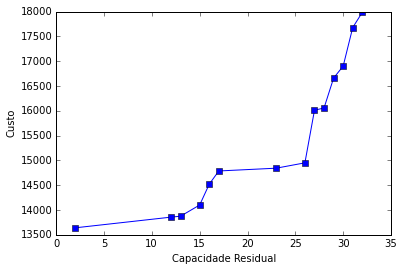

In [74]:
%matplotlib inline

import matplotlib.pyplot as plt

#removing duplicates
seen = set ()
nova = [item for item in result if item[1] not in seen and not seen.add(item[1])]

res = [x[0] for x in nova]
cos = [x[1] for x in nova]

print "Processing time %s" % m.getAttr ('Runtime')

plt.xlabel ('Capacidade Residual')
plt.ylabel ('Custo')
plt.plot (res, cos, 'bs-')
plt.show ()


# Restrição de Qualidade de Serviço

Este restrição visa restingir o tamanho dos caminhos entre nó fonte e destino. Visando evitar que longos caminhos sejam criados entre fonte/destino para cada grupo multicast, assim sendo pode-se buscar soluções com boa qualidade e, ao mesmo tempo, com QoS.

A restrição considera tem como base o número de hops entre fonte/destino.

## Restrição de QoS baseada em número de hops em um caminho:

$$ \sum_{(i,j) \in E} x_{ij}^{kd} <= HOP \quad \forall k \in K, \forall d \in D^k$$

In [286]:
#valor de hop inicial
m.reset ()
HOP = 5

hop_constr = []

# para cada sessão
for k in xrange(1, KSIZE):
    #para cada destino considerar as 
    for d in problem.groups[k-1].members:
        _name='hop',k,d
        #as variáveis que compõe o caminho
        hop_constr.append (
            m.addConstr(
                quicksum(
                     var_x[x] for x in tuplelist (var_x).select ('*','*',k,d)
                )
                <=
                HOP,
                name=str(_name)
            )
        )
m.update ()

## Pegar Pareto com Restrição de Hop:
$$b_{ij}  - \sum_{k \in K} y_{ij}^{k} t^k >= Z \quad \forall (i,j) \in E$$

In [287]:
#Redefine valor para ZMAX
for x in constr:
     x.setAttr('rhs',x.getAttr ('rhs') + Z )
        
m.optimize ()

result = []
time = []

result.append ( (32, m.objVal) )
time.append (m.getAttr ('Runtime'))

for i in xrange(31,-1,-1):
    for c in constr:
        c.setAttr ('rhs',c.getAttr ('rhs') - 1)
    m.update ()
    m.optimize ()    
    result.append ( (i, m.objVal) )
    time.append ( m.getAttr('Runtime') )

## Resultado final - Com restrição de hop

Processing time 0.3337059021


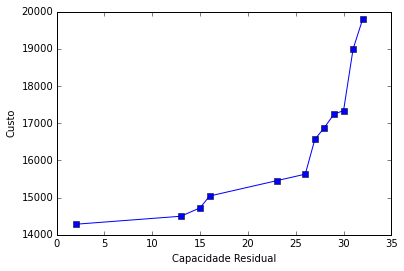

In [289]:
%matplotlib inline

import matplotlib.pyplot as plt

#removing duplicates
seen = set ()
nova2 = [item for item in result if item[1] not in seen and not seen.add(item[1])]

res = [x[0] for x in nova2]
cos = [x[1] for x in nova2]

print "Processing time %s" % m.getAttr ('Runtime')

plt.xlabel ('Capacidade Residual')
plt.ylabel ('Custo')
plt.plot (res, cos, 'bs-')
plt.show ()

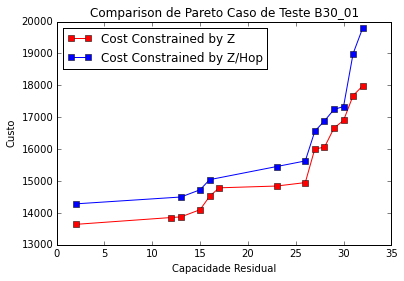

In [306]:
# -*- encoding: utf-8 -*-
res1 = [x[0] for x in nova]
cos1 = [x[1] for x in nova]
label1 = 'Cost Constrained by Z'

res2 = [x[0] for x in nova2]
cos2 = [x[1] for x in nova2]
label2 = 'Cost Constrained by Z/Hop'

plt.xlabel ('Capacidade Residual')
plt.ylabel ('Custo')
plt.title ('Comparison de Pareto Caso de Teste B30_01')

plt.plot (res1, cos1, 'rs-', label=label1)
plt.plot (res2, cos2, 'bs-', label=label2)
plt.legend (loc='upper left')
plt.show ()